In [3]:
# Description: CogSci paper analysis for Experiment 1

# Load libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Load data
trials_PEC_path = '../outputs/all_trials_with_Ri.csv'
trials_PEC = pd.read_csv(trials_PEC_path)

# select only Experiment 1 data
trials_PEC = trials_PEC[trials_PEC['learning_condition'] == 'Experiment 1 (no preview)']

# aggregate accuracy data for each participant and each trial type response_correct and response_correct_mm
aggregated_accuracy = trials_PEC.groupby(['participant_id', 'learning_condition', 'fsm_type', 'test_condition', 'trial_type'])['response_correct', 'response_correct_mm'].mean().reset_index()

# create trials_PEC_long dataframe
trials_PEC_long = pd.melt(aggregated_accuracy, id_vars=['participant_id', 'learning_condition', 'fsm_type', 'test_condition', 'trial_type'],
                            value_vars=['response_correct', 'response_correct_mm'], var_name='accuracy_type', value_name='accuracy')

# aggregate accuracy data for each participant and each trial type
aggregated_accuracy = trials_PEC_long 

/var/folders/l7/9hgxx_dj03s7tlk60qhh11yc0000gn/T/ipykernel_36520/400885782.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  aggregated_accuracy = trials_PEC.groupby(['participant_id', 'learning_condition', 'fsm_type', 'test_condition', 'trial_type'])['response_correct', 'response_correct_mm'].mean().reset_index()


Text(0.5, 1.0, '')

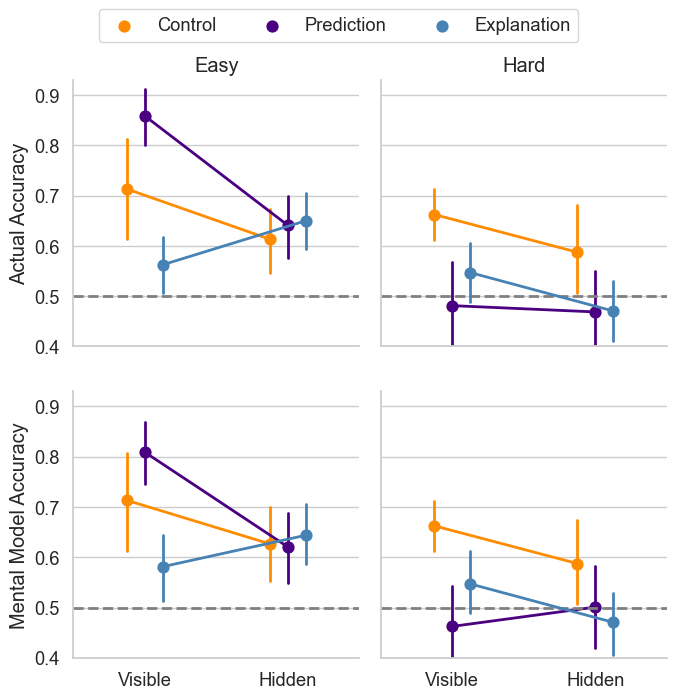

In [5]:
# rename easy to Easy and hard to Hard
aggregated_accuracy['fsm_type'] = aggregated_accuracy['fsm_type'].replace({'easy': 'Easy', 'hard': 'Hard'})

# rename test_condition 
aggregated_accuracy['test_condition'] = aggregated_accuracy['test_condition'].replace({'prediction': 'Prediction', 'control': 'Control', 'explanation': 'Explanation'})
aggregated_accuracy['trial_type'] = aggregated_accuracy['trial_type'].replace({'visible': 'Visible', 'hidden': 'Hidden'})

# convert trial_type and fsm_type to categorical variable with ordered levels
aggregated_accuracy['trial_type'] = pd.Categorical(aggregated_accuracy['trial_type'], categories=['Visible', 'Hidden'], ordered=True)
aggregated_accuracy['fsm_type'] = pd.Categorical(aggregated_accuracy['fsm_type'], categories=['Easy', 'Hard'], ordered=True)

# Plot mean accuracy and 95%CI
sns.set(style="whitegrid", font_scale=1.2) # set style and font size for all plots

g = sns.catplot(x="trial_type", y="accuracy", hue="test_condition", col="fsm_type", row="accuracy_type", data=aggregated_accuracy,
                kind="point", dodge=0.25, join=True, errorbar = ("ci", 95), palette=['darkorange','indigo','steelblue'],
                height=3.5, aspect=1, legend=False) # set legend to False

# make line thiner
for ax in g.axes.flat:
    ax.set_ylim(0.4, 0.93)
    ax.axhline(0.5, ls='--', color='gray')
    for line in ax.lines:
        line.set_linewidth(2)
    
# add different y-axis labels for each row (Actual vs. Mental Model)
g.axes[0,0].set_ylabel("Actual Accuracy")
g.axes[1,0].set_ylabel("Mental Model Accuracy")

# remove x-axis label
g.set_xlabels("")

# add legend to the top center outside of the plot and in 3 rows
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))

# add col names to the top of each column
g.axes[0,0].set_title("Easy")
g.axes[0,1].set_title("Hard")
g.axes[1,0].set_title("")
g.axes[1,1].set_title("")

In [6]:
# Evaluate the difference between MM and actual accuracy with a paired t-test (for participants)
from scipy import stats

# select only actual accuracy
actual_accuracy = aggregated_accuracy[aggregated_accuracy['accuracy_type'] == 'response_correct']

# select only mental model accuracy
mental_model_accuracy = aggregated_accuracy[aggregated_accuracy['accuracy_type'] == 'response_correct_mm']

# make sure that the order of the rows is the same for both dataframes
actual_accuracy = actual_accuracy.sort_values(by=['participant_id', 'learning_condition', 'fsm_type', 'test_condition', 'trial_type'])
mental_model_accuracy = mental_model_accuracy.sort_values(by=['participant_id', 'learning_condition', 'fsm_type', 'test_condition', 'trial_type'])

# check if participant order is the same in both dataframes
np.array_equal(actual_accuracy['participant_id'], mental_model_accuracy['participant_id'])

# run paired t-test
stats.ttest_rel(actual_accuracy['accuracy'], mental_model_accuracy['accuracy'])

# round t to 2 decimal places and p to 3 decimal places
print('t = ' + str(round(stats.ttest_rel(actual_accuracy['accuracy'], mental_model_accuracy['accuracy'])[0], 3)))
print('p = ' + str(round(stats.ttest_rel(actual_accuracy['accuracy'], mental_model_accuracy['accuracy'])[1], 4)))
print(stats.ttest_rel(actual_accuracy['accuracy'], mental_model_accuracy['accuracy']))

# means and standard deviations + number of trials and round float to 2 decimal places
aggregated_accuracy.groupby(['accuracy_type'])['accuracy'].agg(['mean', 'std', 'count']).round(2)

t = 0.899
p = 0.37
TtestResult(statistic=0.8985656572346041, pvalue=0.37000370689599726, df=193)


,mean,std,count
accuracy_type,,,
response_correct,0.6,0.18,194
response_correct_mm,0.6,0.18,194


In [7]:
# run one-sample t-test to check if actual accuracy is significantly different from chance level (0.5) for each test condition, FSM type, and trial type
# select only actual accuracy
actual_accuracy = aggregated_accuracy[aggregated_accuracy['accuracy_type'] == 'response_correct_mm']

# run one-sample t-test for each test condition, FSM type, and trial type
for test_condition in actual_accuracy['test_condition'].unique():
    for fsm_type in actual_accuracy['fsm_type'].unique():
        for trial_type in actual_accuracy['trial_type'].unique():
            results = stats.ttest_1samp(actual_accuracy[(actual_accuracy['test_condition'] == test_condition) & 
                                                    (actual_accuracy['fsm_type'] == fsm_type) & 
                                                    (actual_accuracy['trial_type'] == trial_type)]['accuracy'], popmean = 0.5, alternative='greater')
            print(test_condition + ' ' + fsm_type + ' ' + trial_type + ': t = ' + str(round(results[0], 2)) + '. p = ' + str(round(results[1], 3)))
            print(results) 


Control Hard Hidden: t = 1.92. p = 0.037
TtestResult(statistic=1.9218395710057121, pvalue=0.0369160400682597, df=15)
Control Hard Visible: t = 6.34. p = 0.0
TtestResult(statistic=6.343350474165464, pvalue=6.595141519419105e-06, df=15)
Control Easy Hidden: t = 3.2. p = 0.003
TtestResult(statistic=3.198557367121812, pvalue=0.0032194942429429442, df=14)
Control Easy Visible: t = 4.07. p = 0.001
TtestResult(statistic=4.068694202974834, pvalue=0.0005752014085579291, df=14)
Prediction Hard Hidden: t = 0.02. p = 0.492
TtestResult(statistic=0.02071410288142934, pvalue=0.49187337611599413, df=15)
Prediction Hard Visible: t = -0.82. p = 0.788
TtestResult(statistic=-0.8236455304310201, pvalue=0.7884780498086879, df=15)
Prediction Easy Hidden: t = 3.22. p = 0.003
TtestResult(statistic=3.220620698238445, pvalue=0.002670547647798034, df=16)
Prediction Easy Visible: t = 9.56. p = 0.0
TtestResult(statistic=9.563120447814205, pvalue=2.5476942219403012e-08, df=16)
Explanation Hard Hidden: t = -0.89. p =

In [8]:
# run pairwise t-tests to check if mental model accuracy is different between prediction, explanation and control for each FSM type and trial type (use Bonferroni correction)
import pingouin as pg

mental_model_accuracy = aggregated_accuracy[aggregated_accuracy['accuracy_type'] == 'response_correct_mm']

results = pd.DataFrame()
for fsm_type in mental_model_accuracy['fsm_type'].unique():
    subset = mental_model_accuracy[(mental_model_accuracy['fsm_type'] == fsm_type)].dropna() 
    results_current = pg.pairwise_tests(dv='accuracy', within='trial_type', subject='participant_id', between='test_condition', data=subset, padjust='fdr_bh', effsize='cohen', return_desc=True)
    results_current['fsm_type'] = fsm_type
    results = results.append(results_current)


/Users/roman/Library/CloudStorage/GoogleDrive-roman.tikhonov1@gmail.com/My Drive/openmind-paper/.venv/lib/python3.11/site-packages/pingouin/pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()
/Users/roman/Library/CloudStorage/GoogleDrive-roman.tikhonov1@gmail.com/My Drive/openmind-paper/.venv/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Users/roman/Library/CloudStorage/GoogleDrive-roman.tikhonov1@gmail.com/My Drive/openmind-paper/.venv/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(

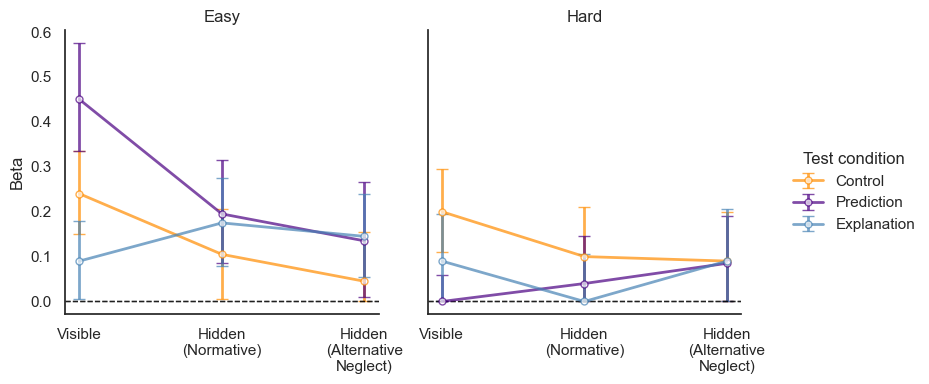

In [20]:
# plot beta and error bars
df = pd.read_csv('../outputs/exp1_beta_with_plus_minus_2LL_errors.csv')

# calculate error size error_low and error_high
df['error_low'] = df['beta_max'] - df['beta_lower']
df['error_high'] = df['beta_higher'] - df['beta_max']

# rename and order tasks
df['task'] = df['task'].replace({'prediction': 'Prediction', 'control': 'Control', 'explanation': 'Explanation'})

df['task'] = pd.Categorical(df['task'], categories=['Control', 'Prediction', 'Explanation'], ordered=True)

def plot_error_bars(x, y, yerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    yerr_values = data[yerr].values.T
    ax.errorbar(data[x], data[y], yerr=yerr_values, fmt='o', capsize=4, elinewidth=2, **kwargs)

sns.set(style="white", font_scale=1) # set style and font size for all plots

# plot mean beta with custom errors (plot_error_bars)
g = sns.FacetGrid(df, col='fsm_type', hue='task', height=4, aspect=1, palette=['darkorange','indigo','steelblue'])

# Map the plot_error_bars function to the data (add white space between bars)
g.map_dataframe(plot_error_bars, x='condition', y='beta_max', yerr=['error_low', 'error_high'], 
                ms=5, mew=1, mfc='white', ls='-', lw=2, alpha=0.7)

# add legend
g.add_legend()

# add legend title
g._legend.set_title('Test condition')

# add titles Easy and Hard for facets
titles = ['Easy', 'Hard']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

# add x values labels Visible, Hidden, Hidden\n(Alternative Neglect)
g.set_xticklabels(['Visible', 'Hidden\n(Normative)', 'Hidden\n(Alternative\nNeglect)'])

# add y axis label
g.set_axis_labels("", "Beta")

# add dashed line at 0
g.map(plt.axhline, y=0, ls='--', c='black', lw=1, alpha=0.5)

In [23]:
# sample descriptives

# load data
participants = pd.read_csv('../data/participants.csv')

# select only participants with learning_condition == 'Experiment 1 (no preview)'
participants = participants[participants['learning_condition'] == 'Experiment 1 (no preview)']

# number of men and women
participants["subject_sex"].value_counts()


Male      49
Female    48
Name: subject_sex, dtype: int64

In [24]:
# age range, mean, and standard deviation
participants["subject_age"].describe()

count    96.00000
mean     27.34375
std       6.73065
min      18.00000
25%      22.00000
50%      26.00000
75%      31.00000
max      47.00000
Name: subject_age, dtype: float64